In [56]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("train_model/data/bitcoin_2017_to_2023.csv")

df = df.dropna()
df = df.reset_index(drop=True)

df["timestamp"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

df = df.sort_values(by=["timestamp"])
# df = df.drop(columns=["timestamp"])
df = df.reset_index(drop=True)

df_len = len(df)
test_size = 0.2
cut_idx = int(df_len* (1 - test_size))
train, val = df.iloc[:cut_idx], df.iloc[cut_idx:]

In [57]:
numeric_cols = ['open', 'high', 'low', 'close'] 
       #          'volume', 'quote_asset_volume',
       # 'number_of_trades', 'taker_buy_base_asset_volume',
       # 'taker_buy_quote_asset_volume']

# scaler = MinMaxScaler(feature_range=(-1, 1))
# train = train.copy()
# train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
# val = val.copy()
# val[numeric_cols] = scaler.transform(val[numeric_cols])

In [62]:
from tslearn.metrics import dtw
import numpy as np
from tqdm import tqdm
from heapq import heappop, heappush

window_size = 100
stride = 50
k = 5
for index in range(0, len(train), stride):
    arr_data = train.iloc[index:index + window_size][numeric_cols].values

    top_k = []
    for target_index in tqdm(range(0, len(train), stride)):
        if index == target_index:
            continue
        
        arr_target = train.iloc[target_index:target_index + window_size][numeric_cols].values
        target_start_date = train.iloc[target_index]["timestamp"]
        cost = dtw(arr_data, arr_target, global_constraint="sakoe_chiba", sakoe_chiba_radius=5)

        if len(top_k) < k:
            heappush(top_k, (-cost, arr_target, target_index))
        else:
            if -cost > top_k[0][0]:
                heappop(top_k)
                heappush(top_k, (-cost, arr_target, target_index))
        
    break

100%|██████████| 50016/50016 [00:40<00:00, 1242.25it/s]


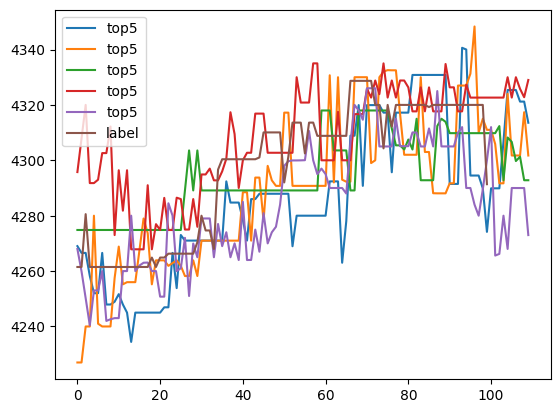

In [84]:
import matplotlib.pyplot as plt

def top_k_vis(label_index, offset=10):
    for i in range(k):
        start_idx = top_k[i][2]
        plt.plot(train.iloc[start_idx: start_idx + window_size+offset].values[:, label_index], label=f"top{k}")
    plt.plot(arr_data[:, 0], label="label")
    plt.legend()

top_k_vis(1)